### SENTIMENT ANALYSIS (IN ARABIC) ###

#### TODO ####
  - Try with a CNN, per: https://arxiv.org/pdf/1702.01923.pdf
  - Better clean input, remove high seq # outliers (Twitter dataset) (from 176 to closer to 20/30)
    - https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings/code (https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text)
  - GRU vs. LSTM (https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm)
  - t-SNE implementation (even though it won't make much sense to non-Arabic reader)
  - Grid Search, across Hyperparams

In [7]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

from matplotlib import pyplot as plt
%matplotlib inline

__[fastText](https://fasttext.cc/)__:
 - 2016, Mikolov [1] (same person who created word2vec)
 - Learning is "fast"
 - Pre-trained word vectors via Facebook Research (https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)
  - Pre-trained word vectors for 294 languages, trained on Wikipedia using fastText. These vectors in dimension 300 were obtained using the skip-gram model described in __[Bojanowski et al. (2016)](https://arxiv.org/abs/1607.04606)__ with default parameters.
 
 
 1. P. Bojanowski*, E. Grave*, A. Joulin, T. Mikolov, __[Enriching Word Vectors with Subword Information](https://arxiv.org/abs/1607.04606)__
 
__[GloVe](http://nlp.stanford.edu/projects/glove/)__:
 - 2014, Stanford NLP
 
__[word2vec](https://code.google.com/archive/p/word2vec/)__:
 - 2013, Mikolov

__[How is GloVe different from word2vec?](https://www.quora.com/How-is-GloVe-different-from-word2vec)__: TL;DR
 - Perform roughtly the same function, but are built differently (Word2Vec is a "predictive" Feed-Fwd NN w/ SGD)
 - GloVe is result of Stanford NLP wanting to build on the Word2Vec concept of "semantic analogies" and yet retain "intrinsic statistical properties of the corpus" (i.e., "word occurrence statistics")

__[GloVe vs word2vec revisited.](http://dsnotes.com/post/glove-enwiki/)__: TL;DR
 - Results are similar enough (maybe GloVe is slightly more accurate)
 - Trade-off: GloVe uses A LOT of RAM/Memory (on order of 15x more!); Word2Vec is 2x slower

#### Credits ####

 - Sentiment Analysis for Arabic Text (tweets, reviews, and standard Arabic) using word2vec
  - https://github.com/iamaziz/ar-embeddings
  - A. Altowayan and L. Tao "Word Embeddings for Arabic Sentiment Analysis", IEEE BigData 2016 Workshop
 - Twitter Data set for Arabic Sentiment Analysis Data Set
  - https://archive.ics.uci.edu/ml/datasets/Twitter+Data+set+for+Arabic+Sentiment+Analysis
  - Abdulla N. A., Mahyoub N. A., Shehab M., Al-Ayyoub M.,Arabic Sentiment Analysis: Corpus-based and Lexicon-based,IEEE conference on Applied Electrical Engineering and Computing Technologies (AEECT 2013),December 3-12, 2013, Amman, Jordan. (Accepted for Publication).
 - arabic-stop-words; 750 words in a text file
  - https://github.com/mohataher/arabic-stop-words

In [9]:
from gensim.models import KeyedVectors
def load_w2v(filepath,binary):
    return KeyedVectors.load_word2vec_format(filepath, binary=binary)

In [10]:
# word2vec (via Aziz Alto), : https://drive.google.com/open?id=0ByiDbCx0i9pEQV9ZUEFIb0hwMmM
# 185 MB; vocab=159175; takes ~5-10 secs to load
#w2v = load_w2v("/home/zmccoy/sandbox/sentiment-analysis-arabic/arabic-news.bin", binary=True)
# --
# fastText (via Facebook Research), Wikipedia: https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.ar.vec
# 1.5 GB; vocab=610977; takes ~3 mins to load
w2v = load_w2v("/home/zmccoy/sandbox/sentiment-analysis-arabic/wiki.ar.vec", binary=False)
print(len(w2v.vocab))

610977


In [11]:
MAX_SEQUENCE_LENGTH = 85 #176 # based on our inputs; TODO: remove outliers? dynamically calculate!
MAX_NB_WORDS = len(w2v.vocab)
EMBEDDING_DIM = 300 # w2v, fastText; GloVe=50

In [12]:
sample = w2v["حسن"]
print(sample.shape)
#print(sample)
print(w2v.most_similar("حسن"))

(300,)
[('،حسن', 0.6795670986175537), ('أبوحسن', 0.6792263388633728), ('#حسن', 0.6771581172943115), ('وحسن', 0.6517007350921631), ('لحسن', 0.6505534648895264), ('\u200fحسن', 0.6446623206138611), ('كحسن', 0.6202388405799866), ('عبدالحسن', 0.6161733865737915), ('بوحسن', 0.6157495379447937), ('د/حسن', 0.6062546968460083)]


In [24]:
import os
import glob
import codecs
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def get_stop_words():
    path = "/home/zmccoy/sandbox/sentiment-analysis-arabic/stop-words-list.txt"
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words

def get_label(path):
    filename = path[path.rfind('/'):]
    if filename.startswith("/pos"):
        return np.array([1, 0])
    return np.array([0, 1])

def get_text(path):
    text = ""
    text_words = []
    # use codecs.open to ingnore non utf-8 encoded chars; instead of "with open(path, 'r') as myfile:"
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        text = myfile.read()
    words = text.split(" ")
    stop_words = get_stop_words()
    for word in words:
        if word not in stop_words:
            text_words.append(word)
    return ' '.join(text_words)

def get_text_sequences(texts):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    #print('Found %s unique tokens.' % len(word_index))
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return data, word_index

def get_data_encoded(path):
    vectors = []
    padded_vectors = []
    unknown_words = []
    labels = []
    all_paths = glob.glob(os.path.join(path,'*.txt'))
    np.random.shuffle(all_paths)
    for path in all_paths:
        # use codecs.open to ingnore non utf-8 encoded chars; instead of "with open(path, 'r') as myfile:"
        with codecs.open(path, "r", encoding='utf-8', errors='ignore') as myfile:
            text = myfile.read()
            word_sequences = text_to_word_sequence(text,
                                        filters='ا\n\ufeff\xa0!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t',
                                        #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                        lower=True,
                                        split=" ")
            vector = []
            for word in word_sequences:
                stop_words = get_stop_words()
                if word not in stop_words:
                    try:
                        vector.append(w2v[word])
                    except KeyError:
                        # TODO: incrementally update w2v with OOVs (out-of-vocabularies)
                        #print("' " + str(word) + "' not in vocabulary")
                        unknown_words.append(word)
            vectors.append(vector)
            label = get_label(path)
            labels.append(label)
    padded_vectors = sequence.pad_sequences(vectors, maxlen=MAX_SEQUENCE_LENGTH)
    return np.array(padded_vectors), np.array(labels), unknown_words
    
def get_data(path):
    texts = []
    labels = []
    all_paths = glob.glob(os.path.join(path,'*.txt'))
    np.random.shuffle(all_paths)
    for path in all_paths: 
        texts.append(get_text(path))
        labels.append(get_label(path))
    sequences, word_index = get_text_sequences(texts)
    return sequences, np.array(labels), word_index

In [20]:
print(get_stop_words())

['،', 'ء', 'ءَ', 'آ', 'آب', 'آذار', 'آض', 'آل', 'آمينَ', 'آناء', 'آنفا', 'آه', 'آهاً', 'آهٍ', 'آهِ', 'أ', 'أبدا', 'أبريل', 'أبو', 'أبٌ', 'أجل', 'أجمع', 'أحد', 'أخبر', 'أخذ', 'أخو', 'أخٌ', 'أربع', 'أربعاء', 'أربعة', 'أربعمئة', 'أربعمائة', 'أرى', 'أسكن', 'أصبح', 'أصلا', 'أضحى', 'أطعم', 'أعطى', 'أعلم', 'أغسطس', 'أفريل', 'أفعل به', 'أفٍّ', 'أقبل', 'أكتوبر', 'أل', 'ألا', 'ألف', 'ألفى', 'أم', 'أما', 'أمام', 'أمامك', 'أمامكَ', 'أمد', 'أمس', 'أمسى', 'أمّا', 'أن', 'أنا', 'أنبأ', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'أنتِ', 'أنشأ', 'أنه', 'أنًّ', 'أنّى', 'أهلا', 'أو', 'أوت', 'أوشك', 'أول', 'أولئك', 'أولاء', 'أولالك', 'أوّهْ', 'أى', 'أي', 'أيا', 'أيار', 'أيضا', 'أيلول', 'أين', 'أيّ', 'أيّان', 'أُفٍّ', 'ؤ', 'إحدى', 'إذ', 'إذا', 'إذاً', 'إذما', 'إذن', 'إزاء', 'إلى', 'إلي', 'إليكم', 'إليكما', 'إليكنّ', 'إليكَ', 'إلَيْكَ', 'إلّا', 'إمّا', 'إن', 'إنَّ', 'إى', 'إياك', 'إياكم', 'إياكما', 'إياكن', 'إيانا', 'إياه', 'إياها', 'إياهم', 'إياهما', 'إياهن', 'إياي', 'إيهٍ', 'ئ', 'ا', 'ا?', 'ا?ى', 'االا', 'االتى', 'اب

In [25]:
word_index_train = {}
word_index_valid = {}
word_index_test = {}
X_train, y_train, word_index_train = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/train")
#X_train, y_train, word_index_train = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/train")
print(X_train.shape)
print(y_train.shape)
print(len(word_index_train))
X_valid, y_valid, word_index_valid = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/valid")
#X_valid, y_valid, word_index_valid = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/valid")
print(X_valid.shape)
print(y_valid.shape)
print(len(word_index_valid))
#X_test, y_test, word_index_test = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/test")
#print(X_test.shape)
#print(y_test.shape)
#print(len(word_index_test))
word_index = {}
for wi in (word_index_train, word_index_valid, word_index_test): word_index.update(wi)
print(len(word_index))

(1800, 85)
(1800, 2)
6447
(200, 85)
(200, 2)
1599
7543


In [26]:
X_train_enc, y_train, unk_train = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/train")
#X_train_enc, y_train, unk_train = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/train")
print(X_train_enc.shape)
print(y_train.shape)
print(len(unk_train))
X_valid_enc, y_valid, unk_valid = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/valid")
#X_valid_enc, y_valid, unk_valid = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/valid")
print(X_valid_enc.shape)
print(y_valid.shape)
print(len(unk_valid))
#X_test_enc, y_test, unk_test = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/test")
#X_test_enc, y_test, unk_test = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/test")
#print(X_test_enc.shape)
#print(y_test.shape)
#print(len(unk_test))

(1800, 85, 300)
(1800, 2)
3958
(200, 85, 300)
(200, 2)
969


In [27]:
def create_embedding_matrix(word_index):
    nb_words = min(MAX_NB_WORDS, len(word_index))+1
    embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
    for word, ii in word_index.items():
        if word in w2v.vocab:
            embedding_matrix[ii] = w2v.word_vec(word)
    return embedding_matrix

embedding_matrix = create_embedding_matrix(word_index)
print(embedding_matrix.shape)

(7544, 300)


In [98]:
embedding_layer = w2v.get_keras_embedding(train_embeddings=False)
print(embedding_layer.input_dim)
print(embedding_layer.output_dim)
#embedding_layer.set_weights(embedding_matrix)
#embedding_layer.get_weights()

610977
300


In [28]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
def get_callbacks(weights_filepath):
    checkpoint = ModelCheckpoint(filepath=weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=4)
    callbacks = [checkpoint, early_stopping]
    return callbacks

In [29]:
def get_model_pretrained_embedding(trainable=False):
    weights_filename = "weights/keras-lstm-pretrained-embedding.h5"
    if trainable is True:
        weights_filename = "weights/keras-lstm-pretrained-embedding-trainable.h5"
    #embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable)
    embedding_layer = w2v.get_keras_embedding(train_embeddings=trainable)
    return get_model_embedding(embedding_layer), weights_filename
    
def get_model_from_scratch_embedding():
    embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)
    return get_model_embedding(embedding_layer), "weights/keras-lstm-from-scratch-embedding.h5"
    
def get_model_embedding(embedding_layer):
    sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
    embeddings = embedding_layer(sentence_indices)   
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    # Returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    X = Dropout(0.5)(X)
    X = Dense(2)(X)
    X = Activation('softmax')(X)
    model = Model(inputs=sentence_indices,outputs=X)
    return model  

def get_model_no_embedding():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(MAX_SEQUENCE_LENGTH,EMBEDDING_DIM)))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    return model, "weights/keras-lstm-no-embedding.h5"

def get_model_pretrained_embedding_bidirectional():
    sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
    embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)
    embeddings = embedding_layer(sentence_indices)   
    X = Bidirectional(LSTM(60, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embeddings)
    X = GlobalMaxPool1D()(X)
    X = Dropout(0.1)(X)
    X = Dense(50)(X)
    X = Activation("relu")(X)
    X = Dropout(0.1)(X)
    X = Dense(2)(X)
    X = Activation('softmax')(X)
    model = Model(inputs=sentence_indices,outputs=X)
    return model, "weights/keras-lstm-pretrained-embedding-bidirectional-trainable.h5"

There are 3 approaches:

 1. Learn embedding from scratch - simply add an Embedding layer to your model
 1. Fine tune learned embeddings - this involves setting word2vec / GloVe vectors as your Embedding layer's weights.
 1. Use word word2vec / Glove word vectors as inputs to your model, instead of one-hot encoding.
 
 
 - (Bidirectional) -see: https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge


In [30]:
#1
model_from_scratch, weights_from_scratch = get_model_from_scratch_embedding()
#2A
model_pt_frozen, weights_pt_frozen = get_model_pretrained_embedding()
#2B
model_pt_trainable, weights_pt_trainable = get_model_pretrained_embedding(trainable=True)
#3
model_no_embedding, weights_no_embedding = get_model_no_embedding()
# Bidirectional
model_bidirectional, weights_bidirectional = get_model_pretrained_embedding_bidirectional()
#model.load_weights(weights_filepath)
#model.summary()

In [31]:
model_from_scratch.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model_pt_frozen.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model_pt_trainable.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model_no_embedding.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model_bidirectional.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [32]:
batch_size = 32
epochs = 10
model_from_scratch.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=get_callbacks(weights_from_scratch))
model_pt_frozen.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=get_callbacks(weights_pt_frozen))
model_pt_trainable.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=get_callbacks(weights_pt_trainable)) 
history = model_no_embedding.fit(X_train_enc, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_enc, y_valid), callbacks=get_callbacks(weights_no_embedding))
model_bidirectional.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=get_callbacks(weights_bidirectional)) 

Train on 1800 samples, validate on 200 samples
Epoch 1/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.6968 - acc: 0.4905
Epoch 00001: val_loss improved from inf to 0.69453, saving model to weights/keras-lstm-from-scratch-embedding.h5
1800/1800 [==============================] - 26s 14ms/step - loss: 0.6967 - acc: 0.4906 - val_loss: 0.6945 - val_acc: 0.4900
Epoch 2/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.6504 - acc: 0.6540
Epoch 00002: val_loss did not improve
1800/1800 [==============================] - 23s 13ms/step - loss: 0.6507 - acc: 0.6533 - val_loss: 0.8813 - val_acc: 0.4500
Epoch 3/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.2467 - acc: 0.9057
Epoch 00003: val_loss did not improve
1800/1800 [==============================] - 27s 15ms/step - loss: 0.2461 - acc: 0.9061 - val_loss: 1.9009 - val_acc: 0.4750
Epoch 4/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.0728 - acc: 0.9782
Epoch 00004: val_

/home/zmccoy/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 183293100 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 1800 samples, validate on 200 samples
Epoch 1/10
1792/1800 [============================>.] - ETA: 1s - loss: 0.7044 - acc: 0.5106
Epoch 00001: val_loss improved from inf to 0.69446, saving model to weights/keras-lstm-pretrained-embedding-trainable.h5
1800/1800 [==============================] - 238s 132ms/step - loss: 0.7045 - acc: 0.5106 - val_loss: 0.6945 - val_acc: 0.4650
Epoch 2/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.6834 - acc: 0.5575
Epoch 00002: val_loss did not improve
1800/1800 [==============================] - 211s 117ms/step - loss: 0.6833 - acc: 0.5578 - val_loss: 0.7104 - val_acc: 0.5000
Epoch 3/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.6071 - acc: 0.6847
Epoch 00003: val_loss did not improve
1800/1800 [==============================] - 204s 113ms/step - loss: 0.6070 - acc: 0.6850 - val_loss: 0.8493 - val_acc: 0.4550
Epoch 4/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.3165 - acc: 0.8577
Epo

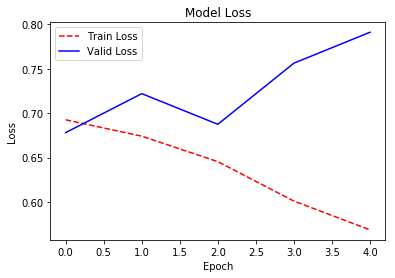

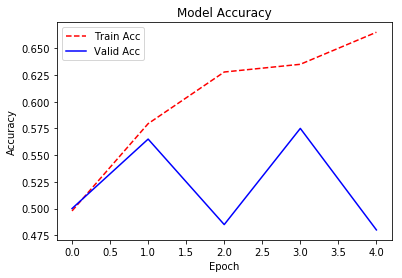

In [33]:
def plot_history(history):
    plt.plot(history.history['loss'],'r--')
    plt.plot(history.history['val_loss'],'b-')
    plt.title('Model Loss')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    plt.plot(history.history['acc'],'r--')
    plt.plot(history.history['val_acc'],'b-')
    plt.title('Model Accuracy')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

# requires history=model.fit, fit_generator...
plot_history(history)

In [34]:
model_from_scratch.load_weights(weights_from_scratch)
model_pt_frozen.load_weights(weights_pt_frozen)
model_pt_trainable.load_weights(weights_pt_trainable)
model_no_embedding.load_weights(weights_no_embedding)
model_bidirectional.load_weights(weights_bidirectional)

In [35]:
X_data, y_data = X_test, y_test
X_data_enc, y_data = X_test_enc, y_test
print("--- FROM SCRATCH EMBEDDINGS ---")
loss, acc = model_from_scratch.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- ARABIC EMBEDDINGS - FROZEN ---")
loss, acc = model_pt_frozen.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- ARABIC EMBEDDINGS - TRAINABLE ---")
loss, acc = model_pt_trainable.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- NO EMBEDDING ---")
loss, acc = model_no_embedding.evaluate(X_data_enc, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE ---")
loss, acc = model_bidirectional.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))

NameError: name 'X_test' is not defined

In [36]:
X_erik_train, y_erik_train, _ = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/train")
X_erik_valid, y_erik_valid, _ = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/valid")
X_erik_test, y_erik_test, _ = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/test")
X_erik = np.concatenate((X_erik_train,X_erik_valid,X_erik_test), axis=0)
y_erik = np.concatenate((y_erik_train,y_erik_valid,y_erik_test), axis=0)
print(X_erik.shape)
print(y_erik.shape)

(525, 85)
(525, 2)


In [37]:
X_erik_train_enc, y_erik_train, _ = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/train")
X_erik_valid_enc, y_erik_valid, _ = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/valid")
X_erik_test_enc, y_erik_test, _ = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/test")
X_erik_enc = np.concatenate((X_erik_train_enc,X_erik_valid_enc,X_erik_test_enc), axis=0)
y_erik = np.concatenate((y_erik_train,y_erik_valid,y_erik_test), axis=0)
print(X_erik_enc.shape)
print(y_erik.shape)

(525, 85, 300)
(525, 2)


In [75]:
X_twitter_train, y_twitter_train, _ = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/train")
X_twitter_valid, y_twitter_valid, _ = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/valid")
X_twitter = np.concatenate((X_twitter_train,X_twitter_valid), axis=0)
y_twitter = np.concatenate((y_twitter_train,y_twitter_valid), axis=0)
print(X_twitter.shape)
print(y_twitter.shape)

(2000, 85)
(2000, 2)


In [74]:
X_twitter_train_enc, y_twitter_train, _ = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/train")
X_twitter_valid_enc, y_twitter_valid, _ = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/valid")
X_twitter_enc = np.concatenate((X_twitter_train_enc,X_twitter_valid_enc), axis=0)
y_twitter = np.concatenate((y_twitter_train,y_twitter_valid), axis=0)
print(X_twitter_enc.shape)
print(y_twitter.shape)

(2000, 85, 300)
(2000, 2)


In [38]:
X_data, y_data = X_erik, y_erik
X_data_enc, y_data = X_erik_enc, y_erik
#X_data, y_data = X_twitter, y_twitter
#X_data_enc, y_data = X_twitter_enc, y_twitter

In [39]:
print("--- FROM SCRATCH EMBEDDINGS ---")
loss, acc = model_from_scratch.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- ARABIC EMBEDDINGS - FROZEN ---")
loss, acc = model_pt_frozen.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- ARABIC EMBEDDINGS - TRAINABLE ---")
loss, acc = model_pt_trainable.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- NO EMBEDDING ---")
loss, acc = model_no_embedding.evaluate(X_data_enc, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE ---")
loss, acc = model_bidirectional.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))

--- FROM SCRATCH EMBEDDINGS ---
525/525 [==============================] - 2s 4ms/step
loss / accuracy = 0.7023 / 0.1981
--- ARABIC EMBEDDINGS - FROZEN ---
525/525 [==============================] - 2s 3ms/step
loss / accuracy = 0.7333 / 0.1105
--- ARABIC EMBEDDINGS - TRAINABLE ---
525/525 [==============================] - 2s 4ms/step
loss / accuracy = 0.7142 / 0.2686
--- NO EMBEDDING ---
525/525 [==============================] - 2s 3ms/step
loss / accuracy = 0.6926 / 0.6152
--- BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE ---
525/525 [==============================] - 1s 2ms/step
loss / accuracy = 0.6336 / 0.8648


In [40]:
def get_predictions(model, X_data, y_data, display=False):
    preds = np.zeros((0,2))
    labels = np.zeros((0,2))
    for ii in range(len(X_data)):
        prediction = model.predict(np.expand_dims(X_data[ii], axis=0))
        label = y_data[ii]
        preds = np.vstack((preds,prediction))
        labels = np.vstack((labels,label))
        if display is True:
            print(prediction)
            print(label)
    return preds, labels

preds, labels = get_predictions(model_bidirectional, X_data, y_data, display=True)
#preds, labels = get_predictions(model_no_embedding, X_data_enc, y_data, display=True)

[[ 0.43361151  0.56638849]]
[0 1]
[[ 0.43797344  0.56202662]]
[0 1]
[[ 0.4871538   0.51284623]]
[0 1]
[[ 0.49115032  0.50884968]]
[0 1]
[[ 0.50159067  0.49840936]]
[0 1]
[[ 0.48351571  0.51648432]]
[0 1]
[[ 0.49443078  0.50556916]]
[0 1]
[[ 0.45593712  0.54406291]]
[0 1]
[[ 0.45716313  0.54283684]]
[0 1]
[[ 0.44520226  0.55479771]]
[0 1]
[[ 0.44149619  0.55850375]]
[0 1]
[[ 0.46386287  0.53613716]]
[0 1]
[[ 0.4507618  0.5492382]]
[0 1]
[[ 0.49024183  0.50975811]]
[0 1]
[[ 0.46664053  0.53335947]]
[0 1]
[[ 0.48411196  0.51588804]]
[0 1]
[[ 0.51821077  0.48178923]]
[1 0]
[[ 0.43972757  0.56027246]]
[0 1]
[[ 0.47426388  0.52573609]]
[0 1]
[[ 0.41714111  0.58285892]]
[0 1]
[[ 0.42593279  0.57406718]]
[0 1]
[[ 0.43666127  0.56333876]]
[1 0]
[[ 0.43590912  0.56409079]]
[0 1]
[[ 0.43561319  0.56438679]]
[0 1]
[[ 0.47973943  0.52026051]]
[0 1]
[[ 0.47588331  0.52411669]]
[0 1]
[[ 0.42623574  0.57376426]]
[0 1]
[[ 0.46010175  0.53989828]]
[0 1]
[[ 0.4254297  0.5745703]]
[0 1]
[[ 0.50159067  0.4

[0 1]
[[ 0.44072333  0.5592767 ]]
[0 1]
[[ 0.4882955  0.5117045]]
[0 1]
[[ 0.45699164  0.54300833]]
[0 1]
[[ 0.48953336  0.51046664]]
[0 1]
[[ 0.48571095  0.51428908]]
[0 1]
[[ 0.44676372  0.55323631]]
[0 1]
[[ 0.46289632  0.53710371]]
[0 1]
[[ 0.4418968  0.5581032]]
[1 0]
[[ 0.47830251  0.52169746]]
[0 1]
[[ 0.41850203  0.58149797]]
[0 1]
[[ 0.49415597  0.50584406]]
[0 1]
[[ 0.49355856  0.50644147]]
[0 1]
[[ 0.42519635  0.57480359]]
[0 1]
[[ 0.4284437   0.57155633]]
[0 1]
[[ 0.46717709  0.53282297]]
[0 1]
[[ 0.44764605  0.55235398]]
[0 1]
[[ 0.44676372  0.55323631]]
[0 1]
[[ 0.43975922  0.56024075]]
[1 0]
[[ 0.49456522  0.50543475]]
[1 0]
[[ 0.4634729   0.53652704]]
[0 1]
[[ 0.45656061  0.54343939]]
[0 1]
[[ 0.47240064  0.52759939]]
[1 0]
[[ 0.47590959  0.52409041]]
[0 1]
[[ 0.4458648   0.55413526]]
[0 1]
[[ 0.47170439  0.52829564]]
[0 1]
[[ 0.50159067  0.49840936]]
[0 1]
[[ 0.47223482  0.52776527]]
[1 0]
[[ 0.49223778  0.50776219]]
[0 1]
[[ 0.45999831  0.54000169]]
[0 1]
[[ 0.4302656

[[ 0.45898774  0.54101223]]
[0 1]
[[ 0.43498111  0.56501895]]
[0 1]
[[ 0.46783352  0.53216654]]
[0 1]
[[ 0.46935496  0.53064501]]
[0 1]
[[ 0.47076625  0.52923381]]
[0 1]
[[ 0.43756971  0.56243032]]
[0 1]
[[ 0.45619521  0.54380476]]
[0 1]
[[ 0.49004981  0.50995016]]
[0 1]
[[ 0.47301233  0.52698767]]
[1 0]
[[ 0.4550077   0.54499227]]
[0 1]
[[ 0.47195199  0.52804804]]
[0 1]
[[ 0.4187642   0.58123571]]
[0 1]
[[ 0.41130325  0.58869672]]
[0 1]
[[ 0.50030977  0.49969023]]
[0 1]
[[ 0.4167954   0.58320463]]
[0 1]
[[ 0.48965871  0.51034135]]
[0 1]
[[ 0.43381453  0.56618553]]
[1 0]
[[ 0.45770463  0.54229534]]
[0 1]
[[ 0.47058684  0.5294131 ]]
[0 1]
[[ 0.43881345  0.56118649]]
[0 1]
[[ 0.44644329  0.55355674]]
[0 1]
[[ 0.43626603  0.56373399]]
[0 1]
[[ 0.45604759  0.54395241]]
[0 1]
[[ 0.46246618  0.53753376]]
[1 0]
[[ 0.43489584  0.56510413]]
[0 1]
[[ 0.46011424  0.53988576]]
[0 1]
[[ 0.46550131  0.53449869]]
[0 1]
[[ 0.43043163  0.56956834]]
[0 1]
[[ 0.45426863  0.54573137]]
[1 0]
[[ 0.47644377 

In [41]:
import itertools
import math
from sklearn.metrics import confusion_matrix

def print_statistics(cm):
    tn, fp, fn, tp = cm.ravel()
    # TP
    print("TP: " + str(tp))
    # TN
    print("TN: " + str(tn))
    # FP
    print("FP: " + str(fp))
    # FN
    print("FN: " + str(fn))
    # TPR
    recall = tp/(tp+fn)
    print("TPR/recall: " + str(recall))
    # TNR
    specificity = tn/(tn+fp)
    print("TNR/specificity: " + str(specificity))
    # PPV
    precision = tp/(tp+fp)
    print("PPV/precision: " + str(precision))
    # NPV
    npv = tn/(tn+fn)
    print("NPV/negative predictive value: " + str(npv))
    # FNR
    miss_rate = 1-recall
    print("FNR/false negative rate: " + str(miss_rate))
    # FPR
    fall_out = 1-specificity
    print("FPR/false positive rate: " + str(fall_out))
    # FDR
    fdr = 1-precision
    print("FDR/false discovery rate: " + str(fdr))
    # FOR
    fomr = 1-npv
    print("FOR/false ommission rate: " + str(fomr))
    # F1
    f1 = 2*((precision*recall)/(precision+recall))
    print("F1 score: " + str(f1))
    # accuracy
    acc = (tp+tn)/(tp+tn+fp+fn)
    print("Accuracy: " + str(acc))
    # Matthews correlation coefficient (MCC)
    mcc = (tp*tn-fp*fn)/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print("MCC/Matthews correlation coefficient: " + str(mcc))
    # Informedness or Bookmaker Informedness (BM)
    bm = recall+specificity-1
    print("BM/Bookmaker Informedness: " + str(bm))
    # Markedness (MK)
    mk = precision+npv-1
    print("MK/Markedness: " + str(mk))
    
    return fall_out, recall

# credit: https://github.com/scikit-learn/scikit-learn/blob/master/examples/model_selection/plot_confusion_matrix.py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    s = [['TN','FP'], ['FN', 'TP']]
    #s = [['TP','FN'], ['FP', 'TN']]
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j,i, (str(s[i][j])+" = "+str(format(cm[i][j],fmt))),horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

TP: 50
TN: 54
FP: 4
FN: 417
TPR/recall: 0.107066381156
TNR/specificity: 0.931034482759
PPV/precision: 0.925925925926
NPV/negative predictive value: 0.114649681529
FNR/false negative rate: 0.892933618844
FPR/false positive rate: 0.0689655172414
FDR/false discovery rate: 0.0740740740741
FOR/false ommission rate: 0.885350318471
F1 score: 0.191938579655
Accuracy: 0.198095238095
MCC/Matthews correlation coefficient: 0.0393187702999
BM/Bookmaker Informedness: 0.0381008639149
MK/Markedness: 0.0405756074546


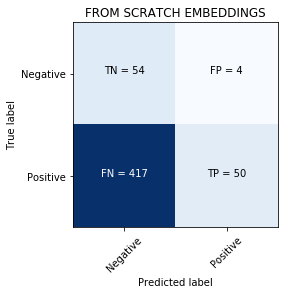

In [42]:
preds, labels = get_predictions(model_from_scratch, X_data, y_data)

y_trues = [np.argmax(ii) for ii in labels]
y_preds = [np.argmax(ii) for ii in preds]

cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='FROM SCRATCH EMBEDDINGS')
plt.show()

TP: 1
TN: 57
FP: 1
FN: 466
TPR/recall: 0.00214132762313
TNR/specificity: 0.98275862069
PPV/precision: 0.5
NPV/negative predictive value: 0.108986615679
FNR/false negative rate: 0.997858672377
FPR/false positive rate: 0.0172413793103
FDR/false discovery rate: 0.5
FOR/false ommission rate: 0.891013384321
F1 score: 0.00426439232409
Accuracy: 0.110476190476
MCC/Matthews correlation coefficient: -0.0768395881928
BM/Bookmaker Informedness: -0.0151000516872
MK/Markedness: -0.391013384321


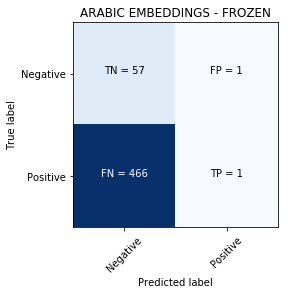

In [43]:
preds, labels = get_predictions(model_pt_frozen, X_data, y_data)

y_trues = [np.argmax(ii) for ii in labels]
y_preds = [np.argmax(ii) for ii in preds]

cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='ARABIC EMBEDDINGS - FROZEN')
plt.show()

TP: 94
TN: 47
FP: 11
FN: 373
TPR/recall: 0.201284796574
TNR/specificity: 0.810344827586
PPV/precision: 0.895238095238
NPV/negative predictive value: 0.111904761905
FNR/false negative rate: 0.798715203426
FPR/false positive rate: 0.189655172414
FDR/false discovery rate: 0.104761904762
FOR/false ommission rate: 0.888095238095
F1 score: 0.328671328671
Accuracy: 0.268571428571
MCC/Matthews correlation coefficient: 0.00911420561544
BM/Bookmaker Informedness: 0.0116296241601
MK/Markedness: 0.00714285714286


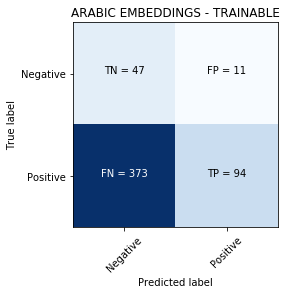

In [44]:
preds, labels = get_predictions(model_pt_trainable, X_data, y_data)

y_trues = [np.argmax(ii) for ii in labels]
y_preds = [np.argmax(ii) for ii in preds]

cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='ARABIC EMBEDDINGS - TRAINABLE')
plt.show()

TP: 304
TN: 19
FP: 39
FN: 163
TPR/recall: 0.65096359743
TNR/specificity: 0.327586206897
PPV/precision: 0.886297376093
NPV/negative predictive value: 0.104395604396
FNR/false negative rate: 0.34903640257
FPR/false positive rate: 0.672413793103
FDR/false discovery rate: 0.113702623907
FOR/false ommission rate: 0.895604395604
F1 score: 0.750617283951
Accuracy: 0.615238095238
MCC/Matthews correlation coefficient: -0.0141293095955
BM/Bookmaker Informedness: -0.021450195673
MK/Markedness: -0.0093070195111


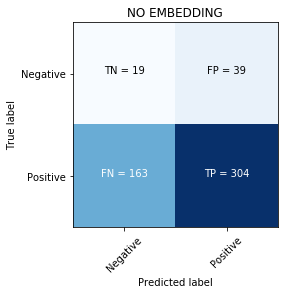

In [45]:
preds, labels = get_predictions(model_no_embedding, X_data_enc, y_data)

y_trues = [np.argmax(ii) for ii in labels]
y_preds = [np.argmax(ii) for ii in preds]

cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='NO EMBEDDING')
plt.show()

TP: 451
TN: 3
FP: 55
FN: 16
TPR/recall: 0.96573875803
TNR/specificity: 0.051724137931
PPV/precision: 0.891304347826
NPV/negative predictive value: 0.157894736842
FNR/false negative rate: 0.03426124197
FPR/false positive rate: 0.948275862069
FDR/false discovery rate: 0.108695652174
FOR/false ommission rate: 0.842105263158
F1 score: 0.927029804728
Accuracy: 0.864761904762
MCC/Matthews correlation coefficient: 0.0293114055777
BM/Bookmaker Informedness: 0.017462895961
MK/Markedness: 0.0491990846682


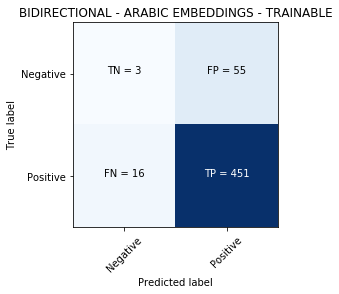

In [46]:
preds, labels = get_predictions(model_bidirectional, X_data, y_data)

y_trues = [np.argmax(ii) for ii in labels]
y_preds = [np.argmax(ii) for ii in preds]

cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE')
plt.show()

TP: 5
TN: 89
FP: 11
FN: 95
TPR/recall: 0.05
TNR/specificity: 0.89
PPV/precision: 0.3125
NPV/negative predictive value: 0.483695652174
FNR/false negative rate: 0.95
FPR/false positive rate: 0.11
FDR/false discovery rate: 0.6875
FOR/false ommission rate: 0.516304347826
F1 score: 0.0862068965517
Accuracy: 0.47
MCC/Matthews correlation coefficient: -0.110581467116
BM/Bookmaker Informedness: -0.06
MK/Markedness: -0.203804347826


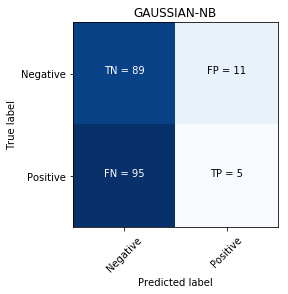

TP: 26
TN: 74
FP: 26
FN: 74
TPR/recall: 0.26
TNR/specificity: 0.74
PPV/precision: 0.5
NPV/negative predictive value: 0.5
FNR/false negative rate: 0.74
FPR/false positive rate: 0.26
FDR/false discovery rate: 0.5
FOR/false ommission rate: 0.5
F1 score: 0.342105263158
Accuracy: 0.5
MCC/Matthews correlation coefficient: 0.0
BM/Bookmaker Informedness: 0.0
MK/Markedness: 0.0


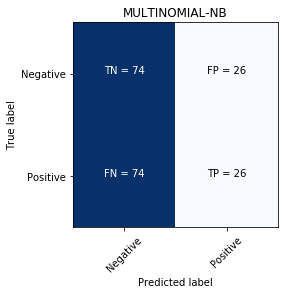

In [47]:
# requires label shape of (m,)
y_train_p = [np.argmax(ii) for ii in y_train]
y_train_p = np.array(y_train_p)
y_valid_p = [np.argmax(ii) for ii in y_valid]
y_valid_p = np.array(y_valid_p)
from sklearn.naive_bayes import GaussianNB, MultinomialNB
gnb = GaussianNB()
y_preds = gnb.fit(X_train, y_train_p).predict(X_valid)
y_trues = y_valid_p
cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)
plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='GAUSSIAN-NB')
plt.show()
#print("GaussianNB: Number of mislabeled points out of a total %d points : %d" % (X_valid.shape[0],(y_valid != y_pred).sum()))
clf = MultinomialNB()
y_preds = clf.fit(X_train, y_train_p).predict(X_valid)
y_trues = y_valid_p
cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)
plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='MULTINOMIAL-NB')
plt.show()
#print("MultinomialNB: Number of mislabeled points out of a total %d points : %d" % (X_valid.shape[0],(y_valid != y_pred).sum()))